In [55]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import datetime
import math
import itertools
from sklearn import preprocessing
import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt

C:\Users\joker\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  after removing the cwd from sys.path.


In [56]:
df1 = pd.read_csv('./SelfData_thesis/0628_self8GData_3to7_ONU16_limitData.csv', usecols=[0], engine='python')
df1.head()

,Ri
0,1074
1,13514
2,14896
3,321
4,341


In [57]:
df2 = pd.read_csv('./SelfData_thesis/0628_self8GData_3to7_ONU16_limitData.csv', usecols=[1], engine='python')
df2.head()

,Ai
0,0
1,12975
2,13822
3,0
4,0


In [58]:
df3 = pd.read_csv('./SelfData_thesis/0628_self8GData_3to7_ONU16_limitData.csv', usecols=[2], engine='python')
df3.head()

,CycleTime
0,0.000367
1,0.000399
2,0.000415
3,0.000375
4,0.000424


In [59]:
df1 = df1.values
df1 = df1.astype('float32')

df2 = df2.values
df2 = df2.astype('float32')

df3 = df3.values
df3 = df3.astype('float32')

In [60]:
print(np.max(df1))
print(np.max(df2))
print(np.max(df3))

df1Max = np.max(df1)
df2Max = np.max(df2)
#df3Max = np.max(df3)

df1 = df1 / np.max(df1) #手動正規化
df2 = df2 / np.max(df2) #手動正規化
#df3 = df3 / np.max(df3) #手動正規化

1120017.0
439485.0
0.00056483


In [61]:
print(len(df1))
print(len(df2))
print(len(df3))

13408
13408
13408


In [62]:
datasetR = df1
datasetA = df2
datasetT = df3

In [63]:
# split into train and test sets
train_sizeR = int(len(datasetR) * 0.8) 
test_sizeR = len(datasetR) - train_sizeR
trainR, testR = datasetR[0:train_sizeR], datasetR[train_sizeR:len(datasetR)]

#scaler = MinMaxScaler(feature_range=(0, 1))
#trainR = scaler.fit_transform(trainR)
#testR = scaler.fit_transform(testR)
print(len(trainR), len(testR))

10726 2682


In [64]:
# split into train and test sets
train_sizeA = int(len(datasetA) * 0.8) 
test_sizeA = len(datasetA) - train_sizeA
trainA, testA = datasetA[0:train_sizeA], datasetA[train_sizeA:len(datasetA)]

#scaler = MinMaxScaler(feature_range=(0, 1))
#trainR = scaler.fit_transform(trainR)
#testR = scaler.fit_transform(testR)
print(len(trainA), len(testA))

10726 2682


In [65]:
# split into train and test sets
train_sizeT = int(len(datasetT) * 0.8) 
test_sizeT = len(datasetT) - train_sizeT
trainT, testT = datasetT[0:train_sizeT], datasetT[train_sizeT:len(datasetT)]

#scaler = MinMaxScaler(feature_range=(0, 1))
#trainR = scaler.fit_transform(trainR)
#testR = scaler.fit_transform(testR)
print(len(trainT), len(testT))

10726 2682


In [66]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

In [67]:
# reshape into X=t and Y=t+1
look_back = 128 #16
trainX_R, trainY_R = create_dataset(trainR, look_back)
testX_R, testY_R = create_dataset(testR, look_back)

trainX_A, trainY_A = create_dataset(trainA, look_back)
testX_A, testY_A = create_dataset(testA, look_back)

trainX_T, trainY_T = create_dataset(trainT, look_back)
testX_T, testY_T = create_dataset(testT, look_back)

In [68]:
# reshape input to be [samples, time steps, features]
trainX_R = np.reshape(trainX_R, (trainX_R.shape[0], look_back, 1))
testX_R = np.reshape(testX_R, (testX_R.shape[0], look_back, 1))

trainX_A = np.reshape(trainX_A, (trainX_A.shape[0], look_back, 1))
testX_A = np.reshape(testX_A, (testX_A.shape[0], look_back, 1))

trainX_T = np.reshape(trainX_T, (trainX_T.shape[0], look_back, 1))
testX_T = np.reshape(testX_T, (testX_T.shape[0], look_back, 1))
#print(trainX.shape[1])

print(trainX_R.shape)
print(trainY_R.shape)
print(testX_R.shape)
print(testY_R.shape)

print(trainX_A.shape)
print(trainY_A.shape)
print(testX_A.shape)
print(testY_A.shape)

print(trainX_T.shape)
print(trainY_T.shape)
print(testX_T.shape)
print(testY_T.shape)

(10597, 128, 1)
(10597, 1)
(2553, 128, 1)
(2553, 1)
(10597, 128, 1)
(10597, 1)
(2553, 128, 1)
(2553, 1)
(10597, 128, 1)
(10597, 1)
(2553, 128, 1)
(2553, 1)


In [69]:
from __future__ import print_function
import math
#importing keras modules
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation ,Dropout , Flatten , Conv1D , MaxPooling1D
from tensorflow.keras.layers import Input, Reshape, concatenate
from tensorflow.keras import losses
from tensorflow.keras import optimizers

In [70]:
inputs_R = Input(shape=(look_back,))
inputs_A = Input(shape=(look_back,))
inputs_T = Input(shape=(look_back,))

inputs_R_test = Reshape((inputs_R.shape[1], 1))(inputs_R)
inputs_A_test = Reshape((inputs_A.shape[1], 1))(inputs_A)
inputs_T_test = Reshape((inputs_R.shape[1], 1))(inputs_T)

In [71]:
Ri_1 = Conv1D(filters=32,kernel_size=1,padding='same',activation='relu',kernel_initializer="glorot_uniform")(inputs_R_test)
Ri_2 = MaxPooling1D(pool_size=2,padding='valid')(Ri_1)
Ri_3 = Conv1D(filters=32,kernel_size=1,padding='same',activation='relu',kernel_initializer="glorot_uniform")(Ri_2)
Ri_4 = MaxPooling1D(pool_size=2,padding='valid')(Ri_3)

Ai_1 = Conv1D(filters=32,kernel_size=1,padding='same',activation='relu',kernel_initializer="glorot_uniform")(inputs_A_test)
Ai_2 = MaxPooling1D(pool_size=2,padding='valid')(Ai_1)
Ai_3 = Conv1D(filters=32,kernel_size=1,padding='same',activation='relu',kernel_initializer="glorot_uniform")(Ai_2)
Ai_4 = MaxPooling1D(pool_size=2,padding='valid')(Ai_3)

Ti_1 = Conv1D(filters=32,kernel_size=1,padding='same',activation='relu',kernel_initializer="glorot_uniform")(inputs_T_test)
Ti_2 = MaxPooling1D(pool_size=2,padding='valid')(Ti_1)
Ti_3 = Conv1D(filters=32,kernel_size=1,padding='same',activation='relu',kernel_initializer="glorot_uniform")(Ti_2)
Ti_4 = MaxPooling1D(pool_size=2,padding='valid')(Ti_3)

Ri_5 = Flatten()(Ri_4)
Ai_5 = Flatten()(Ai_4)
Ti_5 = Flatten()(Ti_4)

out = concatenate([Ri_5, Ai_5, Ti_5], axis = -1)

predictions = Dense(1, activation="relu", kernel_initializer="uniform")(out)

model = Model([inputs_R, inputs_A, inputs_T], outputs = predictions)
model.compile(loss='mse',optimizer='Adam',metrics=['mse','mae'])

In [72]:
print(model.summary())

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_9 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
reshape_6 (Reshape)             (None, 128, 1)       0           input_7[0][0]                    
_______________________________________________________________________________________

In [73]:
from timeit import default_timer as timer
start = timer()
history = model.fit([trainX_R, trainX_A, trainX_T],
                    trainY_A,
                    batch_size=128,
                    epochs=100,
                    validation_split=0.2,
                    verbose=2)
end = timer()
print(end - start)

Epoch 1/100
67/67 - 0s - loss: 0.0021 - mse: 0.0021 - mae: 0.0208 - val_loss: 0.0017 - val_mse: 0.0017 - val_mae: 0.0215
Epoch 2/100
67/67 - 0s - loss: 0.0020 - mse: 0.0020 - mae: 0.0207 - val_loss: 0.0017 - val_mse: 0.0017 - val_mae: 0.0206
Epoch 3/100
67/67 - 0s - loss: 0.0020 - mse: 0.0020 - mae: 0.0203 - val_loss: 0.0018 - val_mse: 0.0018 - val_mae: 0.0216
Epoch 4/100
67/67 - 0s - loss: 0.0020 - mse: 0.0020 - mae: 0.0206 - val_loss: 0.0018 - val_mse: 0.0018 - val_mae: 0.0199
Epoch 5/100
67/67 - 0s - loss: 0.0019 - mse: 0.0019 - mae: 0.0204 - val_loss: 0.0018 - val_mse: 0.0018 - val_mae: 0.0211
Epoch 6/100
67/67 - 0s - loss: 0.0019 - mse: 0.0019 - mae: 0.0204 - val_loss: 0.0018 - val_mse: 0.0018 - val_mae: 0.0199
Epoch 7/100
67/67 - 0s - loss: 0.0019 - mse: 0.0019 - mae: 0.0205 - val_loss: 0.0018 - val_mse: 0.0018 - val_mae: 0.0201
Epoch 8/100
67/67 - 0s - loss: 0.0019 - mse: 0.0019 - mae: 0.0204 - val_loss: 0.0018 - val_mse: 0.0018 - val_mae: 0.0205
Epoch 9/100
67/67 - 0s - loss: 0

Epoch 69/100
67/67 - 0s - loss: 0.0018 - mse: 0.0018 - mae: 0.0199 - val_loss: 0.0018 - val_mse: 0.0018 - val_mae: 0.0203
Epoch 70/100
67/67 - 0s - loss: 0.0018 - mse: 0.0018 - mae: 0.0199 - val_loss: 0.0018 - val_mse: 0.0018 - val_mae: 0.0196
Epoch 71/100
67/67 - 0s - loss: 0.0018 - mse: 0.0018 - mae: 0.0198 - val_loss: 0.0018 - val_mse: 0.0018 - val_mae: 0.0193
Epoch 72/100
67/67 - 0s - loss: 0.0018 - mse: 0.0018 - mae: 0.0199 - val_loss: 0.0018 - val_mse: 0.0018 - val_mae: 0.0203
Epoch 73/100
67/67 - 0s - loss: 0.0019 - mse: 0.0019 - mae: 0.0200 - val_loss: 0.0017 - val_mse: 0.0017 - val_mae: 0.0204
Epoch 74/100
67/67 - 0s - loss: 0.0018 - mse: 0.0018 - mae: 0.0200 - val_loss: 0.0018 - val_mse: 0.0018 - val_mae: 0.0192
Epoch 75/100
67/67 - 0s - loss: 0.0018 - mse: 0.0018 - mae: 0.0200 - val_loss: 0.0018 - val_mse: 0.0018 - val_mae: 0.0195
Epoch 76/100
67/67 - 0s - loss: 0.0018 - mse: 0.0018 - mae: 0.0199 - val_loss: 0.0018 - val_mse: 0.0018 - val_mae: 0.0197
Epoch 77/100
67/67 - 0s 

In [74]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'mse', 'mae', 'val_loss', 'val_mse', 'val_mae'])

timesteps :  128


Text(0.5, 1.0, 'mae')

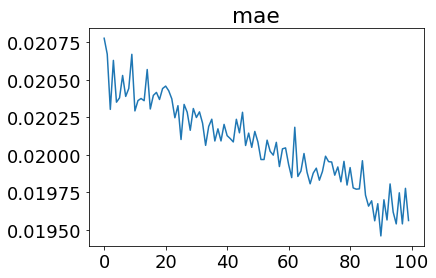

In [75]:
print('timesteps : ', look_back)
plt.plot(history.history['mae'])
plt.title('mae')

timesteps :  128


Text(0.5, 1.0, 'mse')

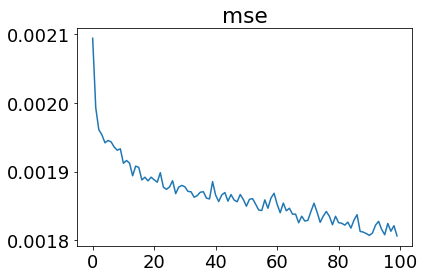

In [76]:
print('timesteps : ', look_back)
plt.plot(history.history['mse'])
plt.title('mse')

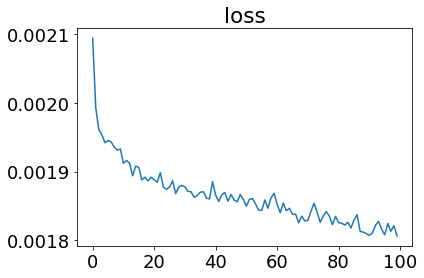

In [77]:
plt.title('loss')
plt.plot(history.history['loss'])

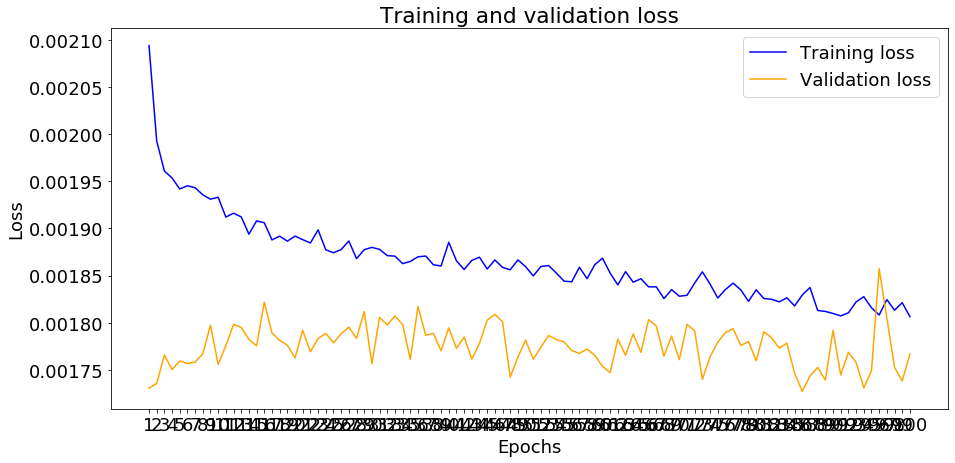

In [78]:
# 画出训练集和验证集的损失曲线

import matplotlib.pyplot as plt

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
loss_values50 = loss_values[0:150]
val_loss_values50 = val_loss_values[0:150]
epochs = range(1, len(loss_values50) + 1)
plt.plot(epochs, loss_values50, 'b',color = 'blue', label='Training loss')
plt.plot(epochs, val_loss_values50, 'b',color='orange', label='Validation loss')
plt.rc('font', size = 18)
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.xticks(epochs)
fig = plt.gcf()
fig.set_size_inches(15,7)
#fig.savefig('img/tcstest&validationlosscnn.png', dpi=300)
plt.show()

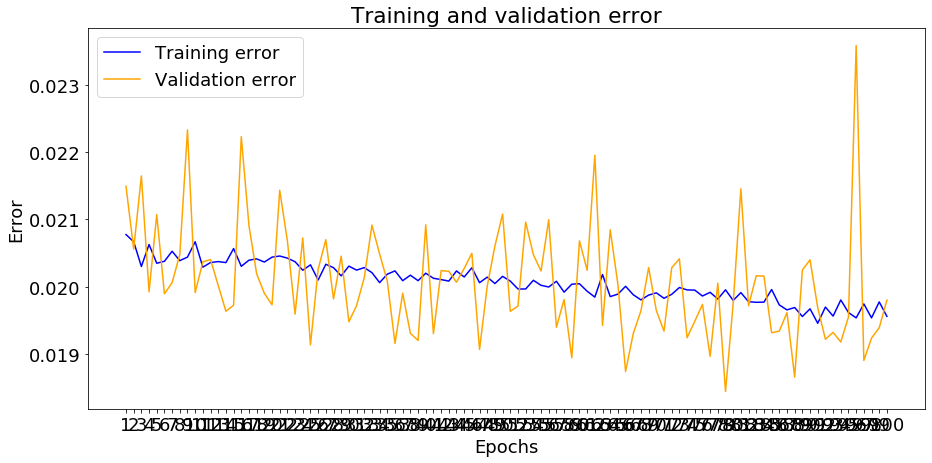

In [79]:
# 画出训练集和验证集的误差图像

#mae = history_dict['mean_absolute_error']
#vmae = history_dict['val_mean_absolute_error']
mae = history.history['mae']
vmae = history.history['val_mae']
epochs = range(1, len(mae) + 1)
plt.plot(epochs, mae, 'b',color = 'blue', label='Training error')
plt.plot(epochs, vmae, 'b',color='orange', label='Validation error')
plt.title('Training and validation error')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.legend()
plt.xticks(epochs)
fig = plt.gcf()
fig.set_size_inches(15,7)
#fig.savefig('img/tcstest&validationerrorcnn.png', dpi=300)
plt.show()

In [80]:
model.metrics_names

trainScore = model.evaluate([trainX_R, trainX_A, trainX_T], trainY_A, verbose=0)
testScore = model.evaluate([testX_R, testX_A, testX_T], testY_A, verbose=0)

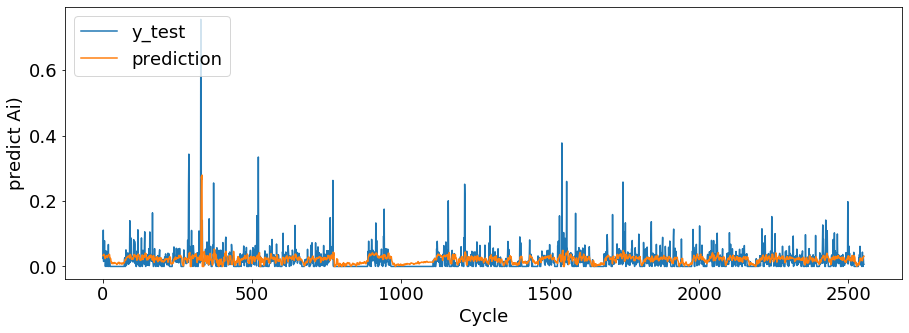

In [81]:
#predicting values for y_test
p = model.predict([testX_R, testX_A, testX_T])

plt.plot(testY_A, label='y_test')
plt.plot(p, label='prediction')
plt.xlabel('Cycle')
plt.ylabel('predict Ai)')
plt.legend(loc='upper left')
fig = plt.gcf()
fig.set_size_inches(15, 5)
#fig.savefig('img/tcstestcnn.png', dpi=300)
plt.show()

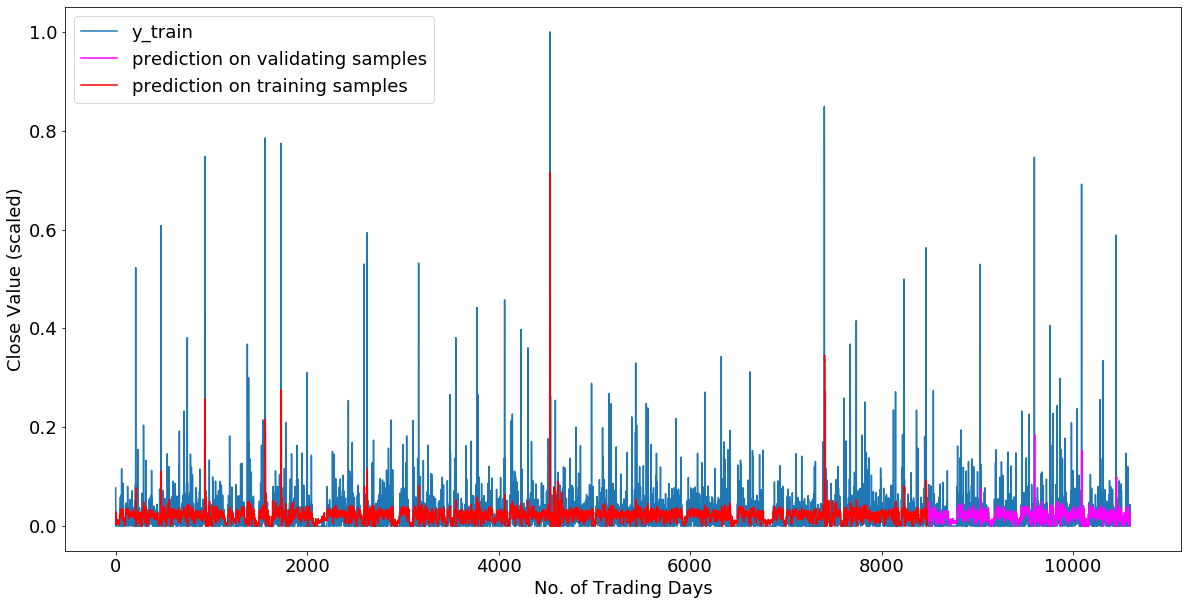

In [82]:
p1 = model.predict([trainX_R, trainX_A, trainX_T])

plt.plot(trainY_A, label='y_train')
x = np.array(range(8477,10597)) #range(x_train shape第一個數字的0.8倍, x_train shape第一個數字)
plt.plot(x,p1[8477:],color = 'magenta',label ='prediction on validating samples') #p1[數字:] 數字代表x_train shape第一個數字的0.8倍
plt.plot(p1[:8477],color='red', label='prediction on training samples')
#x = np.array(range(29512,36890)) #range(x_train shape第一個數字的0.8倍, x_train shape第一個數字)
#plt.plot(x,p1[29512:],color = 'magenta',label ='prediction on validating samples')
#plt.plot(y_train,color='blue', label='y_train')
plt.xlabel('No. of Trading Days')
plt.ylabel('Close Value (scaled)')
plt.legend(loc='upper left')
fig = plt.gcf()
fig.set_size_inches(20,10)
#fig.savefig('img/tcstraincnn.png', dpi=300)
plt.show()

In [83]:
#手動正規化
y = testY_A * df2Max   
y_pred = p.reshape(2553)  
y_pred = y_pred * df2Max   

Ytrain = trainY_A * df2Max
Ytest = testY_A * df2Max

PP = p * df2Max
P1 = p1 * df2Max

In [84]:
from sklearn.metrics import mean_absolute_error

print('Trainscore RMSE \tTrain Mean abs Error \tTestscore Rmse \t Test Mean abs Error')
print('%.9f \t\t %.9f \t\t %.9f \t\t %.9f' % (math.sqrt(trainScore[0]),trainScore[1],math.sqrt(testScore[0]),testScore[1]))

print('mean absolute error \t mean absolute percentage error')
print(' %.9f \t\t\t %.9f' % (mean_absolute_error(y,y_pred),(np.mean(np.abs((y - y_pred) / y)) * 100)))

Trainscore RMSE 	Train Mean abs Error 	Testscore Rmse 	 Test Mean abs Error
0.042139122 		 0.001775706 		 0.034093665 		 0.001162378
mean absolute error 	 mean absolute percentage error
 7842.889160156 			 nan


C:\Users\joker\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
C:\Users\joker\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


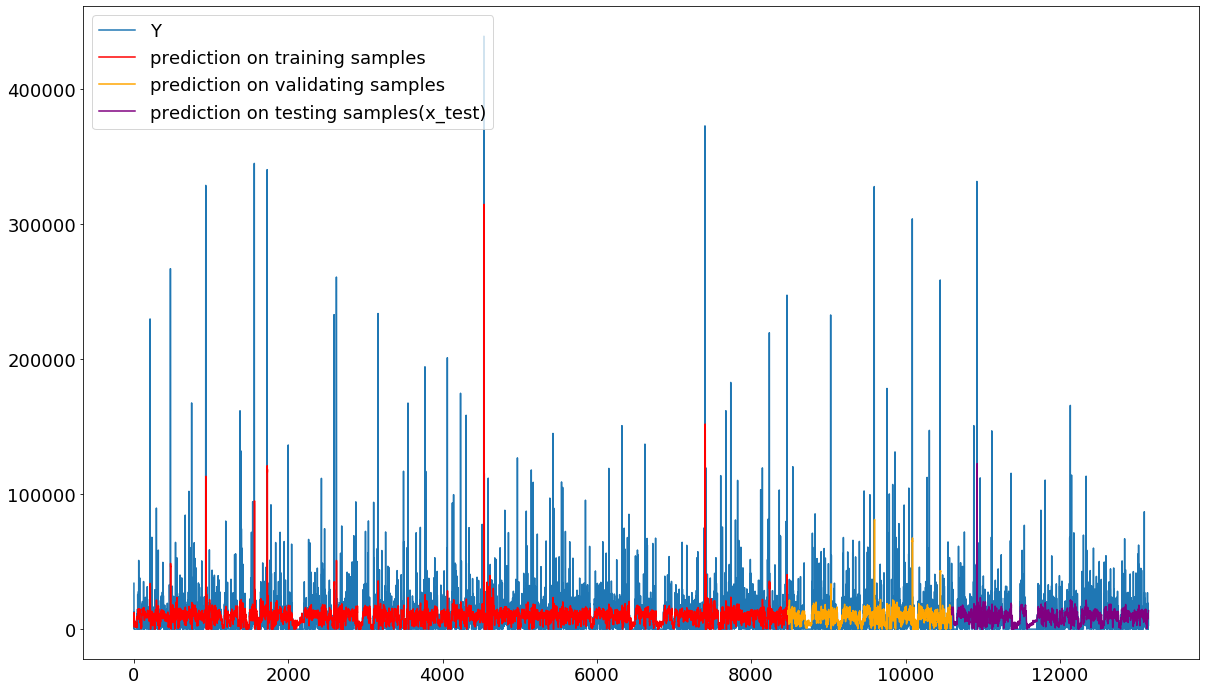

In [85]:
Y = np.concatenate((Ytrain,Ytest),axis = 0)
plt.plot(Y, label='Y')
P = np.concatenate((P1,PP),axis = 0)
#plotting the complete Y set with predicted values on x_train and x_test(variable p1 & p respectively given above)
#for 
plt.plot(P[:8477],color='red', label='prediction on training samples') #p[:數字] 數字代表x_train shape第一個數字的0.8倍
#for validating samples
z = np.array(range(8477,10597)) #range(x_train shape第一個數字的0.8倍, x_train shape第一個數字)
plt.plot(z,P[8477:10597],color = 'orange',label ='prediction on validating samples') #P[x_train shape第一個數字的0.8倍:x_train shape第一個數字]
#for testing samples
x = np.array(range(10597,13150)) #range(x_train shape第一個數字, x_train shape第一個數字 + x_test shape第一個數字)
plt.plot(x,P[10597:],color = 'purple',label ='prediction on testing samples(x_test)') #p[數字:] 數字代表x_train shape第一個數字

#plt.plot(Y,color='blue', label='Y')
plt.legend(loc='upper left')
fig = plt.gcf()
fig.set_size_inches(20,12)
plt.show()

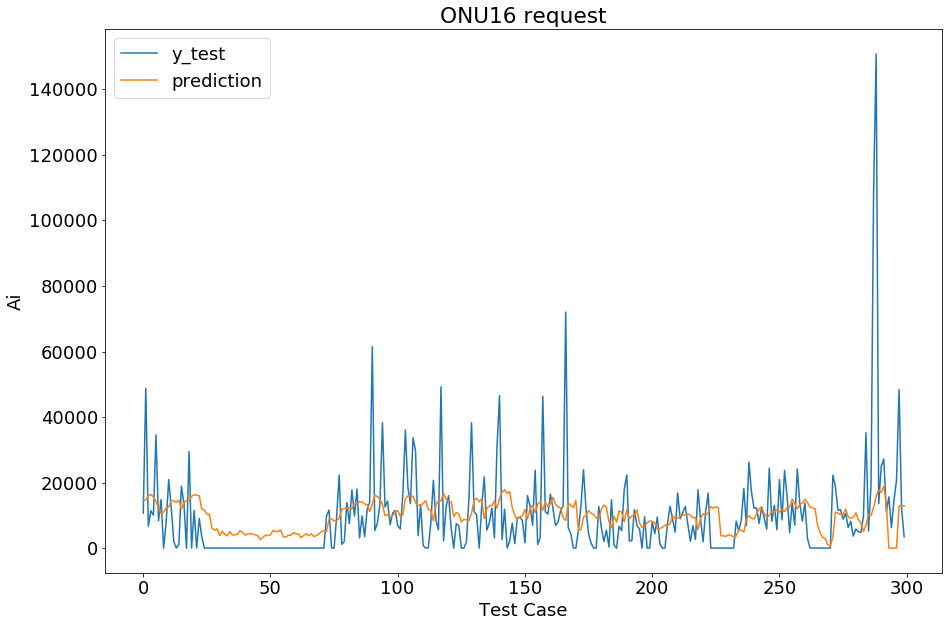

In [86]:
plt.plot(Ytest[:300], label='y_test')
plt.plot(PP[:300], label='prediction')
plt.title('ONU16 request')
plt.xlabel('Test Case')
plt.ylabel('Ai')
plt.legend(loc='upper left')
fig = plt.gcf()
fig.set_size_inches(15, 10)
#fig.savefig('img/tcstestcnn.png', dpi=300)
plt.legend()
plt.show()

In [87]:
model.save('./SelfData_thesis/0629_U08D00_CNN_ONU16_Ri1120017_Ai439485_CycleTi_onuAi_2layer_timesteps128.h5', include_optimizer=False)